In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('final_average_speed.csv')

In [3]:
df.head()

,road_segment,datetime,average_speed
0,0,2019-12-23 05:00:00,37.0
1,0,2019-12-05 05:00:02,42.6
2,0,2019-12-12 05:00:04,39.4
3,0,2019-12-29 05:00:04,35.7
4,0,2019-12-12 05:00:05,30.2


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [5]:
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['is_peakhour'] = df['hour'].apply(lambda x: 1 if (8 <= x <= 11 or 16 <= x <= 18) else 0)
df['is_weekend'] = df['datetime'].dt.dayofweek.apply(lambda x: 1 if x == 5 else 0)

In [6]:
features = ['road_segment','hour', 'minute', 'is_peakhour', 'is_weekend']
target = 'average_speed'

In [7]:
X = df[features].values
y = df[target].values

In [8]:
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

In [9]:
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [10]:
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [12]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    x = Dense(ff_dim, activation="relu")(res)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [13]:
inputs = Input(shape=(1, len(features)))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.2)
x = GlobalAveragePooling1D()(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1)(x)

In [14]:
model = Model(inputs=inputs, outputs=outputs)

In [15]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [16]:
history = model.fit(X_train, y_train, epochs=500, batch_size=64, 
                    validation_split=0.2, verbose=1)

Epoch 1/500


c:\Users\Ripple\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1595 - val_loss: 0.0223
Epoch 2/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0332 - val_loss: 0.0160
Epoch 3/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0242 - val_loss: 0.0154
Epoch 4/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - val_loss: 0.0150
Epoch 5/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165 - val_loss: 0.0146
Epoch 6/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - val_loss: 0.0136
Epoch 7/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0175 - val_loss: 0.0139
Epoch 8/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 - val_loss: 0.0130
Epoch 9/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0145 - val_loss: 0.0133
Epoch 10/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 - val_loss: 0.0129
Epoch 11/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0140 - val_loss: 0.0127
Epoch 12/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129 - val_l

In [17]:
model.save('transformer_average_speed_transformer_model.keras')

In [18]:
loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss (MSE): {loss}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075
Test Loss (MSE): 0.00787823274731636


In [19]:
y_pred_scaled = model.predict(X_test)

 1/33 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step

c:\Users\Ripple\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [20]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

In [21]:
results = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': y_pred.flatten()})
print(results.head())

   Actual  Predicted
0    18.1  20.839334
1    10.1  18.296759
2    19.0  21.741138
3    16.1  16.355158
4    31.7  29.987720


In [22]:
mse = mean_squared_error(y_test_actual, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 20.411003419033953


In [23]:
mae = mean_absolute_error(y_test_actual, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 3.5322889192151887


In [24]:
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 4.5178538510042525


In [25]:
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
print(f'Mean Absolute Percentage Error: {mape}%')

Mean Absolute Percentage Error: 22.015151861352546%


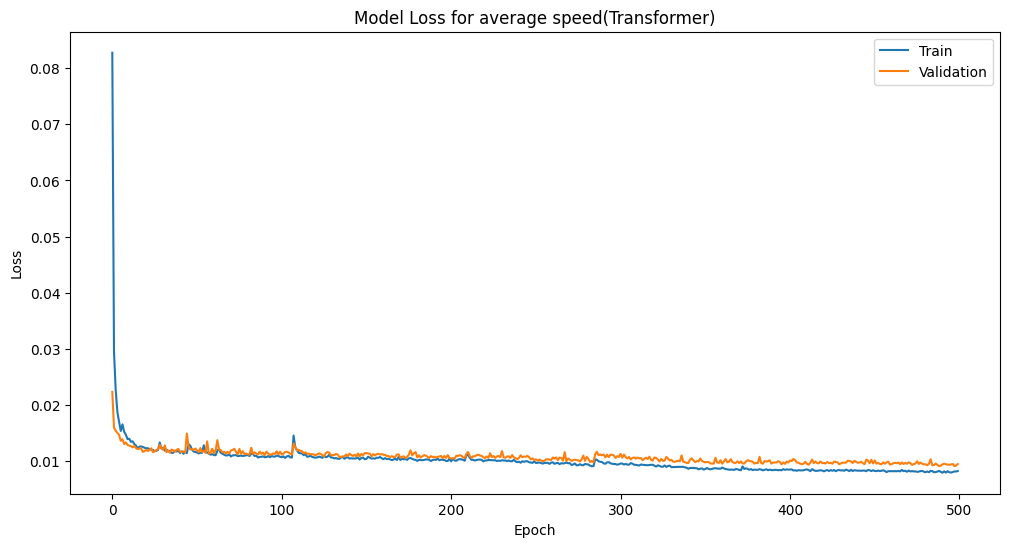

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for average speed(Transformer)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('training_validation_loss.png')
plt.show()

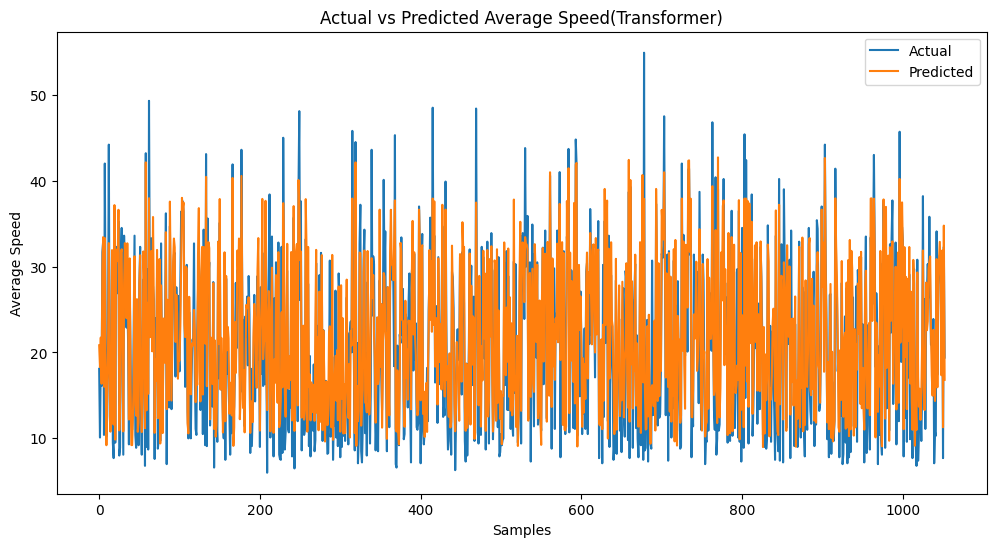

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Average Speed(Transformer)')
plt.xlabel('Samples')
plt.ylabel('Average Speed')
plt.legend()
plt.savefig('Actual vs Predicted Average Speed.png')
plt.show()

In [28]:
import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

In [29]:
def calculate_accuracy(expected_times, actual_times):
    n = len(expected_times)    
    sum_term = sum(1 - abs((expected_times[i] - actual_times[i]) / actual_times[i]) for i in range(n))
    accuracy = (sum_term / n) * 100
    return accuracy
accuracy = calculate_accuracy(y_test_actual.flatten(), y_pred.flatten())
print(f"Accuracy on Validation Set: {accuracy:.2f}%")

Accuracy on Validation Set: 81.24%
